# HW Ranking Data Analysis

Essential imports:

In [83]:
import glob, os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
sns.set_style('white')

### 1. Combining data from multiple files

Concatenating multiple csv files and adding their names to the DataFrame:

In [84]:
all_files = glob.glob("data/*.csv")
li = []
raw_df = pd.concat((pd.read_csv(f).assign(player = f[5:-4]) for f in all_files))

### 2. Decoding and fixing the data

Cleaning up the decoding file, then making a DataFrame out of it:

In [85]:
with open(os.path.join('data', 'DECODING.txt'), 'r') as f:
    lines = f.readlines()
    lines = list(filter(None, [re.sub('\n|[=>]|\'|"|,', '', line) for line in lines]))
decode_dict = {}
current_column = None
for line in lines:
    if line[0].isdigit():
        decode_dict[current_column].append(re.sub('^\d+\s+(.*\s+/\s+)?', '', line))
    else:
        current_column = line
        decode_dict[current_column] = []     

In [86]:
decoding_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in decode_dict.items()]))
decoding_df.index += 1
decoding_df.head()

,results,versions,templates,colors,fractions,heroes
1,Draw,SoD,2sm4d(3),Red,Castle,Orrin
2,Win,WT,Balance,Blue,Rampart,Valeska
3,Lose,Hota,Panic,Green,Tower,Edric
4,NaN,NaN,Jebus Cross,Orange,Inferno,Sylvia
5,NaN,NaN,8mm6,Purple,Necropolis,Lord Haart


Using the just created DataFrame to decode the values:

In [87]:
deciphered_df = raw_df.copy()
deciphered_df['game_template'] = decoding_df.loc[deciphered_df['game_template'], 'templates'].values
deciphered_df['game_version'] = decoding_df.loc[deciphered_df['game_version'], 'versions'].values
deciphered_df['p1_fraction'] = decoding_df.loc[deciphered_df['p1_fraction'], 'fractions'].values
deciphered_df['p2_fraction'] = decoding_df.loc[deciphered_df['p2_fraction'], 'fractions'].values
deciphered_df['p1_hero_start'] = decoding_df.loc[deciphered_df['p1_hero_start'], 'heroes'].values
deciphered_df['p2_hero_start'] = decoding_df.loc[deciphered_df['p2_hero_start'], 'heroes'].values
deciphered_df['p_1_hero_main'] = decoding_df.loc[deciphered_df['p_1_hero_main'], 'heroes'].values
deciphered_df['p2_hero_main'] = decoding_df.loc[deciphered_df['p2_hero_main'], 'heroes'].values
deciphered_df['game_result'] = decoding_df.loc[deciphered_df['game_result'], 'results'].values
deciphered_df['p1'] = True
deciphered_df.dropna(inplace=True)
deciphered_df.reset_index(drop=True, inplace=True)

Fixing wrong match results:

In [88]:
players_ids = {"Drakonin":53651, "Dawidu91":28655, "Jaris":36344,
               "Jelen117":36750, "Szopa666":55968, "Tyranuxus" : 52903}

deciphered_df.loc[(deciphered_df['p2_id'] == deciphered_df['player'].map(players_ids))
                  & (deciphered_df['p2_rating_change'] > 0), ['game_result', 'p1']] = ['Win', False]
deciphered_df.loc[(deciphered_df['p2_id'] == deciphered_df['player'].map(players_ids))
                  & (deciphered_df['p2_rating_change'] < 0), ['game_result', 'p1']] = ['Lose', False]

### 3. Analysis

Ready-to-analyze dataframe:

In [89]:
deciphered_df.head()

,game_date,game_length,game_template,game_version,tournament_id,owner_id,p1_rating,p1_fraction,p1_hero_start,p_1_hero_main,p1_rating_change,p2_id,p2_rating,p2_hero_main,p2_hero_start,p2_fraction,p2_rating_change,game_result,player,p1
0,2018-03-20,127,6lm10a,SoD,96,53651,1500.0,Rampart,Kyrre,Septienna,13.0,44871,1421.0,Tazar,Tazar,Fortress,-13.0,Win,Drakonin,True
1,2018-03-23,122,6lm10a,SoD,96,44871,1391.0,Rampart,Kyrre,Kyrre,21.0,53651,1513.0,Labetha,Labetha,Conflux,-21.0,Lose,Drakonin,False
2,2018-04-04,215,6lm10a,SoD,96,44871,1477.0,Tower,Solmyr,Pyre,17.0,53651,1492.0,Thant,Thant,Necropolis,-17.0,Lose,Drakonin,False
3,2018-04-08,114,6lm10a,SoD,105,53651,1475.0,Tower,Aine,Vidomina,21.0,43242,1608.0,Tazar,Tazar,Fortress,-21.0,Win,Drakonin,True
4,2018-04-08,142,8xm8a,SoD,105,34348,1960.0,Inferno,Calh,Nagash,1.0,53651,1496.0,Crag Hack,Ignissa,Conflux,-1.0,Lose,Drakonin,False


Creating a win percentage table:

In [90]:
deciphered_df['dummy'] = 1
wins_df = deciphered_df.pivot_table(index='player', columns='game_result', 
                                    values='dummy', aggfunc='sum').fillna(0).astype('int')
wins_df = wins_df.iloc[:, ::-1]
wins_df_percent = 100 * wins_df.div(wins_df.sum(axis=1), axis=0)

Creation of win percentage bar plot for all players:

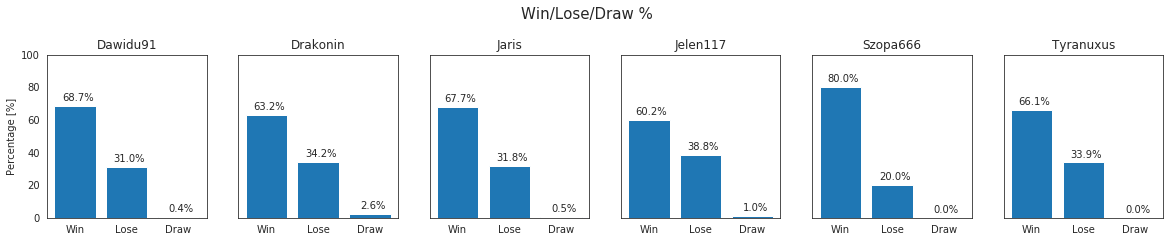

In [91]:
fig, ax = plt.subplots(1, 6, sharey='row', figsize=(20, 3))
fig.suptitle('Win/Lose/Draw %', fontsize=15, y=1.1)
ax[0].set_ylim([0, 100])
ax[0].set_ylabel('Percentage [%]')
for i in range(6):
        ax[i].bar(list(wins_df_percent), wins_df_percent.loc[wins_df_percent.index[i]])
        ax[i].set_title(wins_df_percent.index[i])
        for j, v in enumerate(wins_df_percent.loc[wins_df_percent.index[i]]):
            ax[i].text(j + 0.05, v + 3, str(round(v, 1)) + '%', ha='center')

Creating a time series of rating:

In [92]:
deciphered_df['game_date'] = pd.to_datetime(deciphered_df['game_date'])
deciphered_df['rating'] = np.where(deciphered_df['p1'],
                                   deciphered_df['p1_rating'], deciphered_df['p2_rating'])

In [93]:
rating_df = deciphered_df.loc[:, ('game_date', 'rating', 'player')]

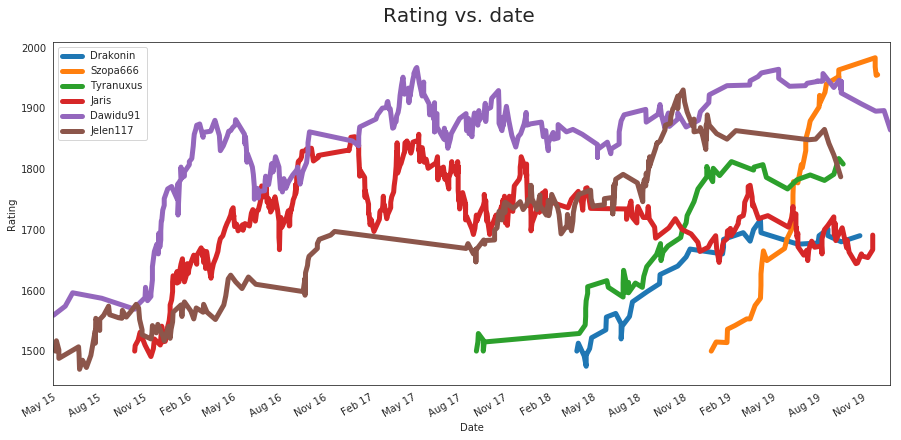

In [94]:
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle('Rating vs. date', fontsize=20, y=0.95)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
for player in rating_df['player'].unique():
    rating_df[rating_df['player'] == player].plot.line(ax=ax, x='game_date', y='rating', label=player, lw=5)
ax.set_xlabel('Date')
ax.set_ylabel('Rating');

Creating a bar plot of games percentage vs. day of the week:

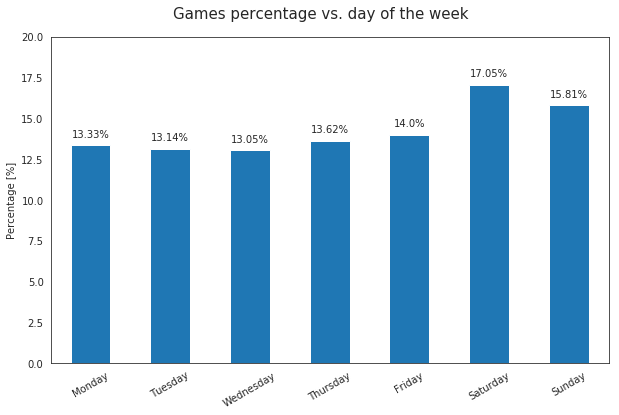

In [95]:
days_ordered = ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')
day_df = deciphered_df.loc[:, ('game_date', 'player')]
day_df['game_date'] = day_df['game_date'].dt.day_name()
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("Games percentage vs. day of the week", fontsize=15, y=0.95)
ax.set_ylabel('Percentage [%]')
ax.set_ylim([0, 20])
day_counts = 100 * day_df['game_date'].value_counts(normalize=True).reindex(index=days_ordered)
ax = day_counts.plot(kind='bar')
ax.set_xticklabels(list(day_counts.index), rotation=30)
for j, v in enumerate(day_counts):
    ax.text(j, v + 0.5, str(round(v, 2)) + '%', ha='center')

Creating a heatmap of matches for all towns:

In [96]:
deciphered_df['player_town'] = np.where(deciphered_df['p1'],
                                   deciphered_df['p1_fraction'], deciphered_df['p2_fraction'])
deciphered_df['opponent_town'] = np.where(deciphered_df['p1'],
                                   deciphered_df['p2_fraction'], deciphered_df['p1_fraction'])
town_table = deciphered_df.pivot_table(index='opponent_town', columns='player_town', values='dummy', aggfunc='sum').fillna(0).astype('int')

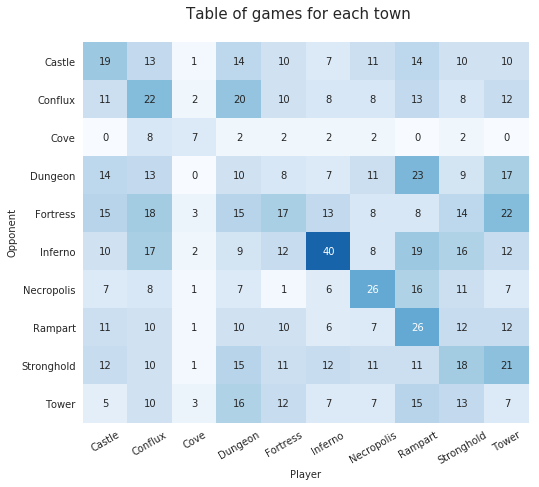

In [109]:
fig, ax = plt.subplots(figsize=(8, 7))
fig.suptitle("Table of games for each town", fontsize=15, y=0.95)
ax = sns.heatmap(data=town_table, cmap='Blues', vmax=50, annot=True, cbar=False)
ax.set_xlabel('Player');
ax.set_ylabel('Opponent');
ax.set_xticklabels(list(town_table.index), rotation=30);

Creating a bar plot of game percentage for towns:

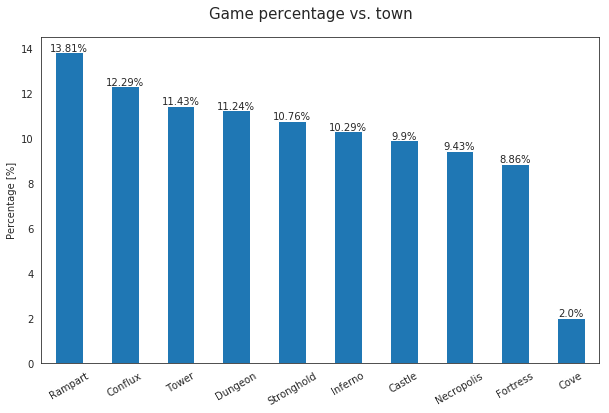

In [98]:
fig, ax = plt.subplots(figsize=(10, 6))
town_percentages = (deciphered_df['player_town'].value_counts()).sort_values(ascending=False)
town_percentages = 100 * town_percentages / town_percentages.sum()
ax = town_percentages.plot(kind='bar')
ax.set_xticklabels(list(town_percentages.index), rotation=30)
ax.set_ylabel('Percentage [%]')
fig.suptitle("Game percentage vs. town", fontsize=15, y=0.95)
for j, v in enumerate(town_percentages):
    ax.text(j, v + 0.05, str(round(v, 2)) + '%', ha='center')

Creation of game percentage vs. town barplots for all players:

In [99]:
playerwise_town_df = deciphered_df.pivot_table(index='player', columns = 'player_town',
                                           values='dummy', aggfunc='sum').fillna(0).astype('int')
playerwise_town_df = 100 * playerwise_town_df.div(playerwise_town_df.sum(axis=1), axis=0)
playerwise_town_df = playerwise_town_df.reindex(sorted(playerwise_town_df.columns), axis=1).iloc[:, ::-1]

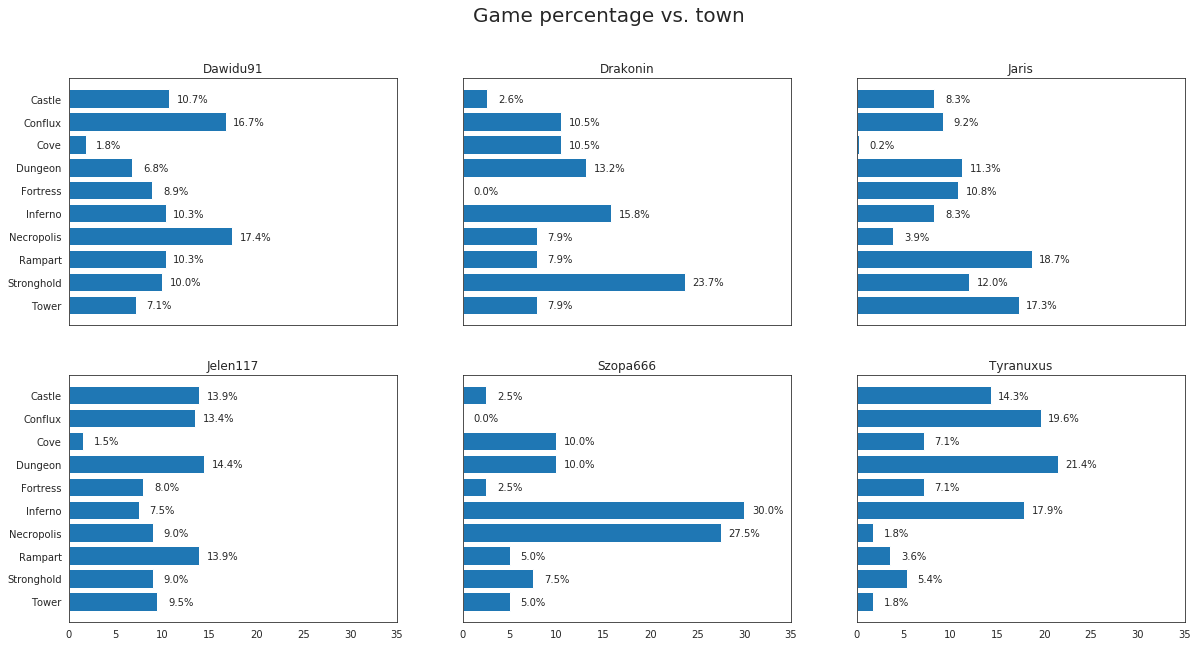

In [100]:
fig, ax = plt.subplots(2, 3, sharey='row', sharex='col', figsize=(20, 10))
fig.suptitle('Game percentage vs. town', fontsize=20)
for i in range(2):
    for j in range(3):
        ax[i, j].set_xlim([0, 35])
        ax[i, j].barh(list(playerwise_town_df), playerwise_town_df.loc[wins_df_percent.index[3 * i + j]])
        ax[i, j].set_title(playerwise_town_df.index[3 * i + j])
        for h, v in enumerate(playerwise_town_df.loc[wins_df_percent.index[3 * i + j]]):
            ax[i, j].text(v + 2.5, h - 0.15, str(round(v, 1)) + '%', ha='center')

        

Creating a win percentage bar plot for towns:

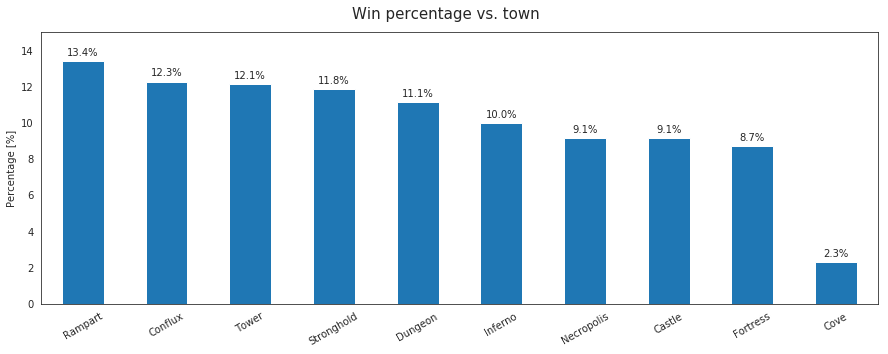

In [104]:
town_wins = deciphered_df.pivot_table(index='player_town', 
                                      columns = 'game_result',
                                      values='dummy', 
                                      aggfunc='sum').fillna(0).astype('int')['Win']
town_wins = 100 * (town_wins / town_wins.sum()).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('Win percentage vs. town', fontsize=15, y=0.95)
ax = town_wins.plot(kind='bar')
ax.set_ylim([0, 15])
ax.set_xticklabels(list(town_wins.index), rotation=30)
ax.set_xlabel('')
ax.set_ylabel('Percentage [%]')
for j, v in enumerate(town_wins):
            ax.text(j, v + 0.3, str(round(v, 1)) + '%', ha='center')